# Instalación y carga de datos

In [ ]:
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementación de BPE


## Funciones auxiliares

Aquí ponermos las funciones auxiliares para utilizar el algoritmo **BPE**

In [ ]:
def generar_caracteres(corpus):
  '''Nos genera un conjunto que separa las palabras en caracteres

  Parámetros
  corpus: Corpus. Lista de oraciones. Las oraciones son listas de palabras
  
  return corpus separado por oraciones y estas separadas en caracteres
  '''
  conjunto = list()
  # por cada oración del corpus
  for oracion in corpus:
    nueva_oracion = list()
    # por cada palabra de la oración
    for palabra in oracion:
      nueva_palabra = list("".join(palabra.split()))
      nueva_oracion.append(nueva_palabra)
    conjunto.append(nueva_oracion)
  
  return conjunto

def generar_pares(conjunto):
  '''Genera los pares de caracteres por palabras

  Parámetro
  conjunto: lista de oraciones de palabras separadas por caracteres

  return pares de caracteres en corpus
  '''
  pares_conjunto = list()
  for oracion in conjunto:
    for palabra in oracion:
      if len(palabra)==1:
        continue
      pares = [palabra[i]+palabra[i+1] for i in range(len(palabra)-1)]
      pares_conjunto.extend(pares)
  
  return pares_conjunto

def freqs_ordenado(freqs):
  '''Regresa una lista con los pares de caracteres y sus frecuencias
  
  Parámetro
  freqs: frecuencia (objeto Counter o diccionario) de las palabras en el
  corpus

  return lista de pares y sus frecuencias
  '''
  # Generamos una lista con los items (key,value) del counter, 
  # ordenandolos por el value (conteo)
  return sorted(freqs.items(), key=itemgetter(1), reverse=True)

def generar_nuevo_conjunto(mf,conjunto):
  '''Genera un nuevo corpus juntando en un caracter el par de caracteres
  más frecuente
  
  Parámetros
  mf: Elemento o par más frecuente
  conjunto: Corpus separado

  return conjunto con el par más frecuente unido
  '''
  # generamos un conjunto de oraciones nuevo
  new_conjunto = list()
  # para cada oración del conjunto 
  for oracion in conjunto:
    new_oracion = list()
    # para cada palabra de la oración
    for palabra in oracion:
      new_palabra = list()
      i = 1
      # si la palabra tiene por lo menos dos caracteres para formar un par
      if len(palabra)>1: 
        # iteramos cada palabra, comparando por pares, empezamos en el 
        # indice 1 pero siempre agregamos el elemento i-1 en caso de no
        # ser parte del par mf. 
        while i < len(palabra):
          # si es parte del par mf
          if palabra[i-1]+palabra[i] == mf:
            new_palabra.append(palabra[i-1]+palabra[i])
            i+=1
          # si no es parte del par mf
          else:
            new_palabra.append(palabra[i-1])
          # Valida si es el último
          if i == len(palabra)-1:
            new_palabra.append(palabra[i])
          i+=1
      # si la palabra tiene solo un elemento
      else:
        # se agrega tal cual a la nueva oración
        new_palabra = palabra
      new_oracion.append(new_palabra)
    # se agrega la nueva oración al nuevo conjunto
    new_conjunto.append(new_oracion)

  return new_conjunto

def limpiar(conjunto):
  '''Regresa una lista con todas las palabras
  
  Parámetros
  conjunto: Corpus, lista de oraciones separadas por palabras

  return corpus en forma de listas de listas caracteres
  '''
  nc = list()
  for oracion in conjunto:
    n_oracion = list()
    for palabra in oracion:
      n_oracion.extend(palabra)
    nc.extend(n_oracion)

  return nc 

Función para calcular la entropía de la representación del corpus. De un modelo del lenguaje.

In [ ]:
def entropia(palabras):
  """
  Calcula la entropía de un conjunto

  Parámetros
  palabras: Corpus en forma de lista de palabras

  return entropía del conjunto
  """
  # Frecuencia de cada simbolo en el vocabulario
  fr = Counter(palabras)
  
  freq = np.array(list(fr.values()))

  # Probabilidad de los simbolos
  p = freq/freq.sum()
  # Entropía del vocabulario
  H = (np.log(p).sum())/(-len(p))

  return H

Función que genera las señalizaciones de continuación de palabras, para el futuro rescate de las traducciones.

In [ ]:
def delimitadorPalabras(lenguaje_BPE):
  '''Genera un corpus de oraciones con los delimitadores
  
  Parámetros
  lenguaje_BPE: Corpus tokenizado

  return corpus agregando @@ para tokens con continuación de palabra
  '''
  lengua_nueva = []
  for oracion in lenguaje_BPE:
    lengua_nueva.append(" ".join(["@@ ".join(palabra) for palabra in oracion]))

  return lengua_nueva

## Implementación concreta, función BPE

In [ ]:
def BPE(corpus, n_iteraciones = 100):
  '''Implementación de BPE
  
  Parámetros
  corpus: corpus de forma lista de oraciones/documentos

  return corpus segmentado por subwords y lista de entropía
  '''
  # separamos por caracteres
  conjunto = generar_caracteres(corpus)

  # Entropias
  H = list()

  # Iteraciones del BPE
  for iteracion in range(n_iteraciones):

    print("ITERACIÓN "+str(iteracion+1),end="")

    # Generamos los pares de caracteres
    pares = generar_pares(conjunto)

    # contamos la frecuencia de los pares en la lista con Counter
    freqs = Counter(pares)
    freqs = freqs_ordenado(freqs)  
    #print("\tFrecuencias:",dict(freqs[:10]))

    # Obtenemos el elemento con mayor frecuencia
    mf = freqs[0][0]
    val = freqs[0][1]
    print("\tMas frecuente: {} \t- {}".format(mf,val))

    # imprimimos el antes y el después
    #print("\tantes:",conjunto[0])
    conjunto = generar_nuevo_conjunto(mf,conjunto)
    #print("\tdespues:",conjunto[0])

    H.append(entropia(limpiar(conjunto)))
  
  return delimitadorPalabras(conjunto),H

# Función que proporciona el preprocesamiento del corpus

In [ ]:
def pre_proceso(corpus, dos_puntos=True):
  """
  Preprocesamiento de datos

  Parámetros
  corpus: Corpus a preprocesar
  dos_puntos: Indica si se deben quitar los dos puntos o no del corpus

  return corpus preprocesado
  """
  # Lo juntamos para poder quitar los elementos no lexicos facilmente
  doc="\n".join(corpus).lower() # Checar si debe estar en minusculas ***********
  # Checar si quitamos números *************************************************
  # Quitamos elementos no lexicos
  no_lex = list("{}¿?[]“”=…\t«»•_¡!;(),.-—*"+'‘'+'"'+'ʼ')
  if dos_puntos:
    no_lex += [":"]
  for nl in no_lex:
    doc=doc.replace(nl,"")
  # Separamos las oraciones por palabras 
  sep = [[ y for y in x.split(" ") if len(y)>0] for x in doc.split("\n")]
  return sep

# Ejecución del algoritmo **BPE**

##Limpieza, preprocesamiento del corpus

In [ ]:
with open("/content/drive/MyDrive/IngenieriaComputacion/NLP/Tenolli/nah.txt","r") as f:
  nahuatl = f.readlines()

with open("/content/drive/MyDrive/IngenieriaComputacion/NLP/Tenolli/esp.txt","r") as f:
  español = f.readlines()

corpus_nahuatl = pre_proceso(nahuatl, False)
corpus_español = pre_proceso(español, False)

##Ejecución de **BPE**
Se decidió dar las mismas iteraciones a ambos corpus para evitar que haya problemas al momento de tratar de alinear las oraciones

In [ ]:
nuevo_nahuatl, h_nahuatl = BPE(corpus_nahuatl,157)

ITERACIÓN 1	Mas frecuente: hu 	- 74662
ITERACIÓN 2	Mas frecuente: tl 	- 68707
ITERACIÓN 3	Mas frecuente: in 	- 65391
ITERACIÓN 4	Mas frecuente: an 	- 55296
ITERACIÓN 5	Mas frecuente: hua 	- 37053
ITERACIÓN 6	Mas frecuente: qu 	- 36795
ITERACIÓN 7	Mas frecuente: ti 	- 35500
ITERACIÓN 8	Mas frecuente: ca 	- 34715
ITERACIÓN 9	Mas frecuente: mo 	- 32413
ITERACIÓN 10	Mas frecuente: ch 	- 31371
ITERACIÓN 11	Mas frecuente: te 	- 30105
ITERACIÓN 12	Mas frecuente: :n 	- 29869
ITERACIÓN 13	Mas frecuente: ma 	- 27782
ITERACIÓN 14	Mas frecuente: tla 	- 26347
ITERACIÓN 15	Mas frecuente: to 	- 25815
ITERACIÓN 16	Mas frecuente: li 	- 25617
ITERACIÓN 17	Mas frecuente: tz 	- 24587
ITERACIÓN 18	Mas frecuente: qui 	- 21055
ITERACIÓN 19	Mas frecuente: pa 	- 20599
ITERACIÓN 20	Mas frecuente: cu 	- 19884
ITERACIÓN 21	Mas frecuente: ze 	- 19275
ITERACIÓN 22	Mas frecuente: hui 	- 18894
ITERACIÓN 23	Mas frecuente: ki 	- 18696
ITERACIÓN 24	Mas frecuente: chi 	- 18430
ITERACIÓN 25	Mas frecuente: uh 	- 18010
ITER

In [ ]:
nuevo_español,h_español = BPE(corpus_español,157)

ITERACIÓN 1	Mas frecuente: es 	- 53716
ITERACIÓN 2	Mas frecuente: en 	- 46203
ITERACIÓN 3	Mas frecuente: os 	- 42085
ITERACIÓN 4	Mas frecuente: de 	- 39247
ITERACIÓN 5	Mas frecuente: la 	- 38424
ITERACIÓN 6	Mas frecuente: an 	- 31660
ITERACIÓN 7	Mas frecuente: ue 	- 31523
ITERACIÓN 8	Mas frecuente: er 	- 27271
ITERACIÓN 9	Mas frecuente: ar 	- 27167
ITERACIÓN 10	Mas frecuente: on 	- 27050
ITERACIÓN 11	Mas frecuente: as 	- 26786
ITERACIÓN 12	Mas frecuente: se 	- 23348
ITERACIÓN 13	Mas frecuente: que 	- 21241
ITERACIÓN 14	Mas frecuente: or 	- 20510
ITERACIÓN 15	Mas frecuente: al 	- 20381
ITERACIÓN 16	Mas frecuente: el 	- 18469
ITERACIÓN 17	Mas frecuente: te 	- 16941
ITERACIÓN 18	Mas frecuente: co 	- 15562
ITERACIÓN 19	Mas frecuente: ta 	- 14796
ITERACIÓN 20	Mas frecuente: to 	- 14391
ITERACIÓN 21	Mas frecuente: ci 	- 14193
ITERACIÓN 22	Mas frecuente: do 	- 13979
ITERACIÓN 23	Mas frecuente: ti 	- 12615
ITERACIÓN 24	Mas frecuente: re 	- 12423
ITERACIÓN 25	Mas frecuente: los 	- 12374
ITERACI

In [ ]:
with open("/content/drive/MyDrive/IngenieriaComputacion/NLP/Tenolli/tokens_paralelos.txt","w") as file:
  for esp, nah in zip(nuevo_español,nuevo_nahuatl):
    file.write(nah+"\t"+esp+"\n")

# Resultados

## Gráfica de evolución de la entropía separada por lengua

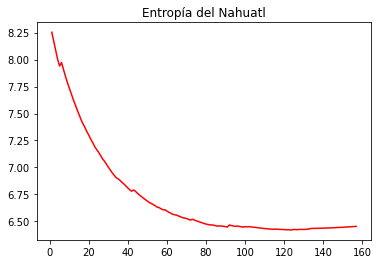

In [ ]:
# mostrando la entropia 
plt.plot(range(1,len(h_nahuatl)+1),h_nahuatl,c="red")
plt.title("Entropía del Nahuatl")
plt.show()

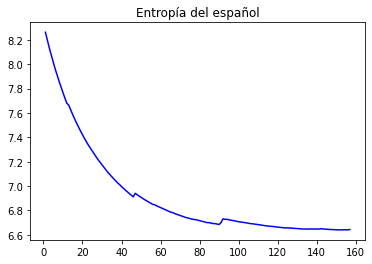

In [ ]:
plt.plot(range(1,len(h_español)+1),h_español,c="blue")
plt.title("Entropía del español")
plt.show()

## Gráfica de la evolución de la entropía de ambas lenguas

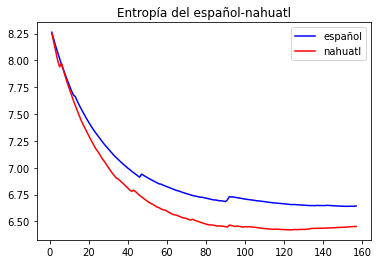

In [ ]:
plt.plot(range(1,len(h_español)+1),h_español,c="blue",label="español")
plt.plot(range(1,len(h_nahuatl)+1),h_nahuatl,c="red",label="nahuatl")
plt.title("Entropía del español-nahuatl")
plt.legend()
plt.show()

## Curvas de Zipf

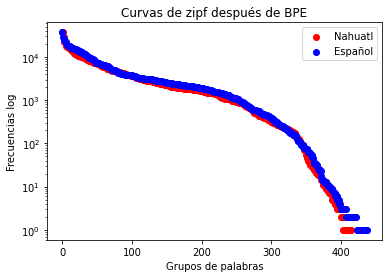

In [ ]:
from itertools import chain
freqs_nahuatl = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_nahuatl])))
freqs_español = Counter(list(chain(*[oracion.split(" ") 
                      for oracion in nuevo_español])))
zipf_nahuatl = [x[1] for x in freqs_ordenado(freqs_nahuatl)]
zipf_español = [x[1] for x in freqs_ordenado(freqs_español)]

plt.scatter(range(len(zipf_nahuatl)),zipf_nahuatl,color="red",label="Nahuatl")
plt.scatter(range(len(zipf_español)),zipf_español,color="blue",label="Español")
plt.yscale("log")
plt.legend()
plt.ylabel("Frecuencias log")
plt.xlabel("Grupos de palabras")
plt.title("Curvas de zipf después de BPE")
plt.show()